Прочитайте базу my_BRENT2019.csv и перейдите к представлению ряда первыми разностями

Добавьте первые разности по стоимости доллара и евро к рублю

сделайте ее перрасчет (ресемплинг) в представление по неделям.

Постройте модель предсказания 1-й точки от текущей (h=1).

Сделайте вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns

import itertools

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.simplefilter('ignore')

**Прочитайте базу my_BRENT2019.csv и перейдите к представлению ряда первыми разностями.  
Добавьте первые разности по стоимости доллара и евро к рублю**

In [2]:
#Path_Energy = "D:\AI\Machine learning\my_BRENT2019.csv"
Path_Energy = 'D:/AI/Machine learning/my_BRENT2019.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

data.head(3)

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0


"D:\AI\Machine learning\RC_F01_09_2010_T01_09_2019.xlsx"  
"D:\AI\Machine learning\R_E01_09_2010_T01_09_2019.xlsx"

In [3]:
r_d = pd.read_excel('D:/AI/Machine learning/RC_F01_09_2010_T01_09_2019.xlsx', index_col=1, usecols=2)

In [4]:
r_d = r_d.drop(columns='nominal')

In [5]:
r_d.head(3)

,curs
data,
2010-09-01,30.8669
2010-09-02,30.8001
2010-09-03,30.6858


In [6]:
r_e = pd.read_excel('D:/AI/Machine learning/R_E01_09_2010_T01_09_2019.xlsx', index_col=1, usecols=2)
r_e = r_e.drop(columns='nominal')

In [7]:
r_e.head(3)

,curs
data,
2010-09-01,39.0127
2010-09-02,39.1654
2010-09-03,39.2901


In [8]:
r_d.rename(columns={"curs": "US_dollar"}, inplace=True)
r_e.rename(columns={"curs": "Euro" }, inplace=True)
data.rename(columns={"Значение": "target"}, inplace=True)

In [9]:
r_d.index = pd.to_datetime(r_d.index)
r_e.index = pd.to_datetime(r_e.index)

In [10]:
brent_df= pd.concat([data,r_d,r_e], axis=1)

In [11]:
brent_df.head(3)

,target,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,US_dollar,Euro
2010-09-01,76.37,2010.0,9.0,1.0,3.0,244.0,35.0,2.0,0.0,0.0,0.0,30.8669,39.0127
2010-09-02,76.89,2010.0,9.0,2.0,3.0,245.0,35.0,3.0,0.0,0.0,0.0,30.8001,39.1654
2010-09-03,76.57,2010.0,9.0,3.0,3.0,246.0,35.0,4.0,0.0,0.0,0.0,30.6858,39.2901


In [12]:
brent_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3137 entries, 2010-09-01 to 2019-09-01
Data columns (total 13 columns):
target             2667 non-null float64
year               2667 non-null float64
month              2667 non-null float64
dayofmonth         2667 non-null float64
quarter            2667 non-null float64
dayofyear          2667 non-null float64
weekofyear         2667 non-null float64
dayofweek          2667 non-null float64
is_holiday         2667 non-null float64
is_prev_holiday    2667 non-null float64
is_next_holiday    2667 non-null float64
US_dollar          2228 non-null float64
Euro               2228 non-null float64
dtypes: float64(13)
memory usage: 343.1 KB


We see plenty of NaN values. 

In [13]:
brent_df.loc[brent_df['target'].isna(), :]

,target,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,US_dollar,Euro
2010-09-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.0826,40.8115
2010-09-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.9480,41.2599
2010-10-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.5094,41.6606
2010-10-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.9086,41.6717
2010-10-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.1243,42.3939
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.6423,71.7077
2019-08-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.2543,73.0196
2019-08-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.9961,73.2227
2019-08-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.6046,72.6243


In [14]:
brent_df.loc[brent_df['US_dollar'].isna(), :]

,target,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,US_dollar,Euro
2010-09-05,76.63,2010.0,9.0,5.0,3.0,248.0,35.0,6.0,0.0,1.0,0.0,NaN,NaN
2010-09-06,76.87,2010.0,9.0,6.0,3.0,249.0,36.0,0.0,1.0,0.0,0.0,NaN,NaN
2010-09-13,79.19,2010.0,9.0,13.0,3.0,256.0,37.0,0.0,0.0,0.0,0.0,NaN,NaN
2010-09-19,78.23,2010.0,9.0,19.0,3.0,262.0,37.0,6.0,0.0,0.0,0.0,NaN,NaN
2010-09-20,79.36,2010.0,9.0,20.0,3.0,263.0,38.0,0.0,0.0,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-18,58.89,2019.0,8.0,18.0,3.0,230.0,33.0,6.0,0.0,0.0,0.0,NaN,NaN
2019-08-19,59.74,2019.0,8.0,19.0,3.0,231.0,34.0,0.0,0.0,0.0,0.0,NaN,NaN
2019-08-25,57.81,2019.0,8.0,25.0,3.0,237.0,34.0,6.0,0.0,0.0,0.0,NaN,NaN
2019-08-26,58.26,2019.0,8.0,26.0,3.0,238.0,35.0,0.0,0.0,0.0,0.0,NaN,NaN


In [15]:
brent_df.loc[brent_df['Euro'].isna(), :]

,target,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,US_dollar,Euro
2010-09-05,76.63,2010.0,9.0,5.0,3.0,248.0,35.0,6.0,0.0,1.0,0.0,NaN,NaN
2010-09-06,76.87,2010.0,9.0,6.0,3.0,249.0,36.0,0.0,1.0,0.0,0.0,NaN,NaN
2010-09-13,79.19,2010.0,9.0,13.0,3.0,256.0,37.0,0.0,0.0,0.0,0.0,NaN,NaN
2010-09-19,78.23,2010.0,9.0,19.0,3.0,262.0,37.0,6.0,0.0,0.0,0.0,NaN,NaN
2010-09-20,79.36,2010.0,9.0,20.0,3.0,263.0,38.0,0.0,0.0,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-18,58.89,2019.0,8.0,18.0,3.0,230.0,33.0,6.0,0.0,0.0,0.0,NaN,NaN
2019-08-19,59.74,2019.0,8.0,19.0,3.0,231.0,34.0,0.0,0.0,0.0,0.0,NaN,NaN
2019-08-25,57.81,2019.0,8.0,25.0,3.0,237.0,34.0,6.0,0.0,0.0,0.0,NaN,NaN
2019-08-26,58.26,2019.0,8.0,26.0,3.0,238.0,35.0,0.0,0.0,0.0,0.0,NaN,NaN


In [16]:
#  количество строк без курсов доллара и евро совпадаeт - 909. проверим, совпадают ли
brent_df.loc[(brent_df['US_dollar'].isna() & brent_df['Euro'].isna()), :]

,target,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,US_dollar,Euro
2010-09-05,76.63,2010.0,9.0,5.0,3.0,248.0,35.0,6.0,0.0,1.0,0.0,NaN,NaN
2010-09-06,76.87,2010.0,9.0,6.0,3.0,249.0,36.0,0.0,1.0,0.0,0.0,NaN,NaN
2010-09-13,79.19,2010.0,9.0,13.0,3.0,256.0,37.0,0.0,0.0,0.0,0.0,NaN,NaN
2010-09-19,78.23,2010.0,9.0,19.0,3.0,262.0,37.0,6.0,0.0,0.0,0.0,NaN,NaN
2010-09-20,79.36,2010.0,9.0,20.0,3.0,263.0,38.0,0.0,0.0,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-18,58.89,2019.0,8.0,18.0,3.0,230.0,33.0,6.0,0.0,0.0,0.0,NaN,NaN
2019-08-19,59.74,2019.0,8.0,19.0,3.0,231.0,34.0,0.0,0.0,0.0,0.0,NaN,NaN
2019-08-25,57.81,2019.0,8.0,25.0,3.0,237.0,34.0,6.0,0.0,0.0,0.0,NaN,NaN
2019-08-26,58.26,2019.0,8.0,26.0,3.0,238.0,35.0,0.0,0.0,0.0,0.0,NaN,NaN


In [17]:
#есть ли совпадающие без цены нефти и курсов
brent_df.loc[(brent_df['Euro'].isna() & brent_df['target'].isna()), :]

,target,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,US_dollar,Euro


In [18]:
#brent_df.loc[:,['target','US_dollar', 'Euro']].fillna(method='pad', axis='columns', inplace=True)

In [19]:
brent_df.fillna(method='pad',inplace=True)

In [20]:
brent_df['2010-12-20': '2011-01-03']

,target,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,US_dollar,Euro
2010-12-20,92.60,2010.0,12.0,20.0,4.0,354.0,51.0,0.0,0.0,0.0,0.0,30.6682,40.7979
2010-12-21,93.50,2010.0,12.0,21.0,4.0,355.0,51.0,1.0,0.0,0.0,0.0,30.7746,40.5055
2010-12-22,93.80,2010.0,12.0,22.0,4.0,356.0,51.0,2.0,0.0,0.0,0.0,30.7188,40.4720
2010-12-23,94.32,2010.0,12.0,23.0,4.0,357.0,51.0,3.0,0.0,1.0,0.0,30.7187,40.3582
2010-12-24,93.46,2010.0,12.0,24.0,4.0,358.0,51.0,4.0,1.0,0.0,0.0,30.5922,40.1706
2010-12-25,93.46,2010.0,12.0,24.0,4.0,358.0,51.0,4.0,1.0,0.0,0.0,30.5778,40.1548
2010-12-26,93.55,2010.0,12.0,26.0,4.0,360.0,51.0,6.0,0.0,0.0,0.0,30.5778,40.1548
2010-12-27,93.71,2010.0,12.0,27.0,4.0,361.0,52.0,0.0,0.0,0.0,0.0,30.5778,40.1548
2010-12-28,94.21,2010.0,12.0,28.0,4.0,362.0,52.0,1.0,0.0,0.0,0.0,30.4495,40.0594
2010-12-29,94.03,2010.0,12.0,29.0,4.0,363.0,52.0,2.0,0.0,0.0,0.0,30.2720,40.0226


In [21]:
brent_df.drop(columns=['year','month', 'quarter', 'weekofyear', 'dayofweek', 'is_holiday',
                       'is_prev_holiday', 'is_next_holiday', 'dayofmonth','dayofyear'], inplace=True)

In [22]:
brent_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3137 entries, 2010-09-01 to 2019-09-01
Data columns (total 3 columns):
target       3137 non-null float64
US_dollar    3137 non-null float64
Euro         3137 non-null float64
dtypes: float64(3)
memory usage: 178.0 KB


In [23]:
brent_df['Target_diff_1'] = brent_df['target'].diff(1)
brent_df['US_dollar_diff_1'] = brent_df['US_dollar'].diff(1)
brent_df['Euro_diff_1'] = brent_df['Euro'].diff(1)

In [35]:
brent_df.dropna();

In [41]:
brent_week = brent_df.resample('W').mean()

In [42]:
brent_week.head()

,target,US_dollar,Euro,Target_diff_1,US_dollar_diff_1,Euro_diff_1
2010-09-05,76.616000,30.747440,39.233840,0.065000,-0.043675,0.084450
2010-09-12,77.673333,30.777050,39.302883,0.288333,0.033583,-0.026467
2010-09-19,78.590000,30.887129,39.984557,-0.018571,0.026986,0.231400
2010-09-26,78.558571,31.003800,41.040657,0.101429,-0.019229,0.064057
2010-10-03,81.582857,30.585086,41.382686,0.678571,-0.062657,0.057243


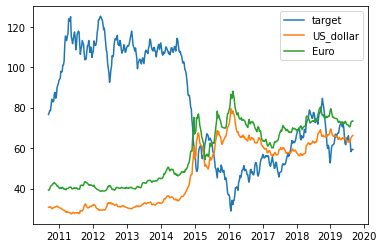

In [43]:
for col in range(3):
    plt.plot(brent_week.iloc[:,col], label=f'{brent_week.columns[col]}')
plt.legend()

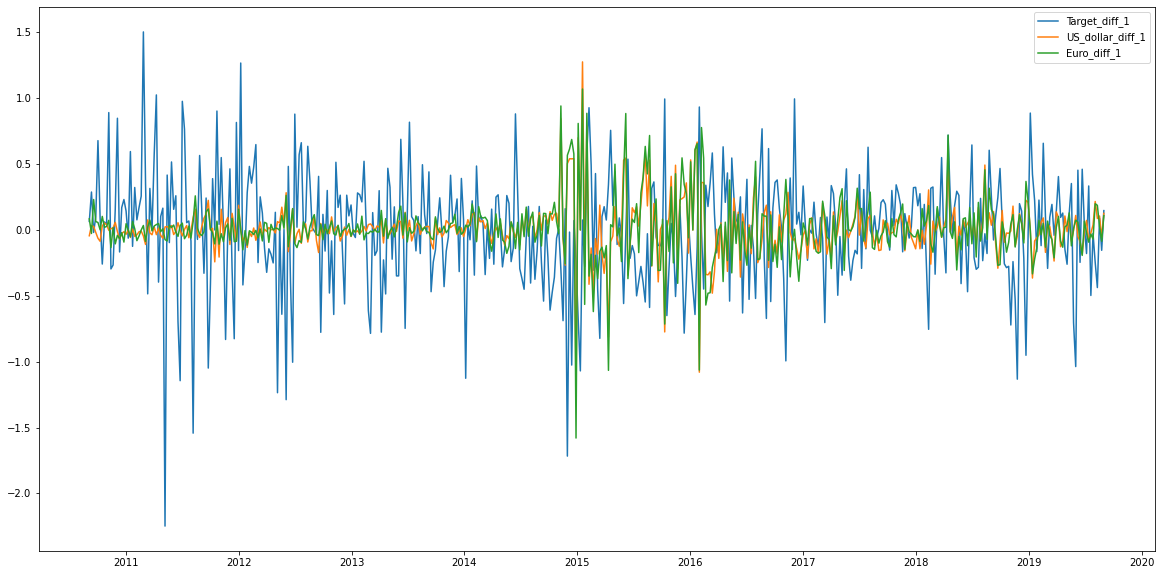

In [44]:
plt.figure( figsize=( 20, 10 ))
for col in range(3,6):
    plt.plot(brent_week.iloc[:,col], label=f'{brent_week.columns[col]}')
plt.legend()